In [2]:
import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files (전처리)
acq = read_csv_auto_dates("./clean_data_v1/clean_acquisitions_final.csv")
deg = read_csv_auto_dates("./clean_data_v1/clean_degrees_final.csv")
frs = read_csv_auto_dates("./clean_data_v1/clean_fr_final.csv")
fds = read_csv_auto_dates("./clean_data_v1/clean_funds_final.csv")
inv = read_csv_auto_dates("./clean_data_v1/clean_investments_final.csv")
ipo = read_csv_auto_dates("./clean_data_v1/clean_ipos_final.csv")
mil = read_csv_auto_dates("./clean_data_v1/clean_milestones_final.csv")
obj = read_csv_auto_dates("./clean_data_v1/clean_objects_final.csv")
peo = read_csv_auto_dates("./clean_data_v1/clean_people_final.csv")
off = read_csv_auto_dates("./clean_data_v1/clean_offices_final.csv")
rel = read_csv_auto_dates("./clean_data_v1/clean_relationships_final.csv")

# Load Files (작업용 전처리)
company = read_csv_auto_dates("./entity_type/objects_company.csv")
finorg = read_csv_auto_dates("./entity_type/objects_finorg.csv")
person = read_csv_auto_dates("./entity_type/objects_person.csv")
product = read_csv_auto_dates("./entity_type/objects_product.csv")


print("="*60)
print("Dataset 로드 완료!")
print("="*60)

Dataset 로드 완료!


In [3]:
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


# 한글 안깨지게 맥북용
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 가설 검정 1 테이블 조인

### [스타트업의 특성] → 투자 여부

3-1. vc의 투자 의사결정은 스타트업의 특징에 따라 유의미한 영향을 미친다.

(변수: 산업, 지역, 라운드, 조달 금액 공개여부, 사무실 위치, 관계 변화량)

## objects 테이블, offices 테이블 조인

### office 집계
grain = 스타트업 (objects)

1. cat_offices_description == 'Headquarters'
2. objects.obj_city_fixed 와 city가 일치하는 office
3. office 중 첫 번째 city

In [4]:
# objects 컬럼 선택
cols_use = [
    #objects
    'objects_cfpr_id', 'founded_at', 'closed_at', 'description', 'country_code', 'obj_city_fixed', 'first_investment_at',
    'last_investment_at', 'investment_rounds', 'invested_companies', 'first_funding_at', 'last_funding_at', 'funding_rounds',
    'funding_total_usd', 'relationships', 'cat_obj_status', 'obj_category_filled', 'cat_obj_overview', 'obj_state_filled', 
    'is_obj_funding_total_usd_private'
]
obj = obj[cols_use].copy()

In [5]:
# Headquarters 우선 선택
hq = (
    off[off['cat_offices_description'] == 'Headquarters']
    [['offices_c_id','office_id', 'city']]
    .drop_duplicates('offices_c_id')
    )

# hq 없는 회사
hq_ids = set(hq['offices_c_id'])

off_no_hq = off[~off['offices_c_id'].isin(hq_ids)].copy()

# objects city와 일치하는 office 찾기
obj_city = (
    obj[['objects_cfpr_id', 'obj_city_fixed']]
    .rename(columns={'objects_cfpr_id': 'offices_c_id'}
    )
)

off_no_hq_cmp = off_no_hq.merge(
    obj_city,
    on='offices_c_id',
    how='left'
)

city_match = (
    off_no_hq_cmp[
        off_no_hq_cmp['city'] == off_no_hq_cmp['obj_city_fixed']]
    [['offices_c_id', 'office_id', 'city']]
    .drop_duplicates('offices_c_id')
)

# 그래도 안 남은 회사들
matched_ids = set(city_match['offices_c_id'])

off_fallback = (
    off_no_hq[~off_no_hq['offices_c_id'].isin(matched_ids)]
    .sort_values(['offices_c_id', 'office_id'])   # office_id 기준 정렬
    .groupby('offices_c_id', as_index=False)
    .first()                                      # 가장 작은 office_id 선택
    [['offices_c_id','office_id', 'city']]
)

# 최종 office_city 테이블 완성
office_city_final = pd.concat(
    [hq, city_match, off_fallback],
    ignore_index=True
)
# 컬럼명 office city 명확하게
office_city_final = office_city_final.rename(columns={'city': 'office_city'})

office_city_final


,offices_c_id,office_id,office_city
0,c:3,3,Pleasanton
1,c:5,5,Menlo Park
2,c:9,9,West Hollywood
3,c:15,15,San Francisco
4,c:18,17,Palo Alto
...,...,...,...
95038,f:9973,82250,San Francisco
95039,f:9981,82405,Bruxelles
95040,f:9985,91646,San Francisco
95041,f:9994,105168,Unknown


In [6]:
# objects 기준으로 조인
startup_profile = (
    obj
    .merge(
        office_city_final,
        left_on='objects_cfpr_id',
        right_on='offices_c_id',
        how='left'
    )
)

startup_profile['office_id'] = startup_profile['office_id'].astype('Int64')


### startup_profile (object, office) + relationships 테이블 조인

### Relationships 테이블 파생변수 붙이기
관계량 = 전체 관계 수 - 현재 관계 수 

- 전체 관계 수: rel_cf_id 기준 rel_p_id 개수
- 과거 관계 수: is_past == 1 인 관계 수
- 현재 관계 수: is_past == 0 인 관계 수

In [7]:
# rel 관계변화량 파생변수 생성

# 관계 수 집계 (rel_cf_id 기준)
rel_agg = (
    rel
    .groupby('rel_cf_id')
    .agg(
        total_relationship_cnt = ('rel_p_id', 'nunique'),   # 전체 관계 수
        current_relationship_cnt = ('is_past', lambda x: (x == 0).sum())
    )
    .reset_index()
)

# 관계 변화량 파생변수 생성
rel_agg['relationship_growth'] = (
    rel_agg['total_relationship_cnt']
    - rel_agg['current_relationship_cnt']
)

# startup_profile에 조인
startup_profile = (
    startup_profile
    .merge(
        rel_agg[['rel_cf_id', 'relationship_growth']],
        left_on='objects_cfpr_id',
        right_on='rel_cf_id',
        how='left'
    )
)    
startup_profile['relationship_growth'] = (
    startup_profile['relationship_growth']
    .fillna(0)
    .astype('Int64')
)

In [8]:
# # csv 쓰기 (데이터 프레임 편집, 분석한 데이터 프레임 저장)
# startup_profile.to_csv('startup_profile.csv', index=False)
# print("전처리된 데이터를 startup_profile.csv 파일로 저장했습니다.")

### startup_profile (object, office, relationships) + funding_rounds 테이블 조인

### funding_rounds 테이블 조인 및 집계

- fr_c_id 별로 
- funding_round_type : 최초 라운드(VC가 처음 본 단계) 
    - 이유: 이후 정보 누수 적음

In [9]:
# funding_rounds 컬럼 선택
cols_use = [
    #funding_rounds
    'funding_round_id', 'fr_c_id', 'funded_at', 'raised_amount_usd', 'participants', 'is_first_round', 'is_last_round',
    'cat_fr_type', 'num_fr_type', 'is_fr_raised_private'
]
frs = frs[cols_use].copy()

In [10]:
# 회사별 최초 투자 라운드 추출

fr_first = (
    frs
    .sort_values(['fr_c_id', 'funded_at'])   # 회사별 시간순 정렬
    .groupby('fr_c_id', as_index=False)
    .first()
    [['funding_round_id','fr_c_id', 'cat_fr_type', 'num_fr_type', 'raised_amount_usd', 'is_fr_raised_private']]
    )

# startup_profile에 조인
startup_profile = (
    startup_profile
    .merge(
        fr_first[['funding_round_id','fr_c_id', 'cat_fr_type', 'num_fr_type', 'raised_amount_usd', 'is_fr_raised_private']],
        left_on='objects_cfpr_id',
        right_on='fr_c_id',
        how='left'
    )
    .drop(columns=['fr_c_id'])
)

startup_profile['num_fr_type'] = startup_profile['num_fr_type'].fillna(0).astype('Int64')
startup_profile['is_fr_raised_private'] = startup_profile['is_fr_raised_private'].fillna(0).astype('Int64')


In [11]:
startup_profile

,objects_cfpr_id,founded_at,closed_at,description,country_code,obj_city_fixed,first_investment_at,last_investment_at,investment_rounds,invested_companies,...,offices_c_id,office_id,office_city,rel_cf_id,relationship_growth,funding_round_id,cat_fr_type,num_fr_type,raised_amount_usd,is_fr_raised_private
0,c:1,2005-10-17,NaT,Technology Platform Company,USA,seattle,NaT,NaT,0,0,...,c:1,1,Seattle,c:1,7,888.0,series-a,1,5250000.0,0
1,c:10,NaT,NaT,NaN,USA,culver city,NaT,NaT,0,0,...,c:10,10,Culver City,c:10,6,NaN,NaN,0,NaN,0
2,c:100,NaT,NaT,NaN,USA,san mateo,NaT,NaT,0,0,...,c:100,97,San Mateo,c:100,8,NaN,NaN,0,NaN,0
3,c:10000,2008-07-26,NaT,NaN,NaN,NaN,NaT,NaT,0,0,...,NaN,<NA>,NaN,NaN,0,NaN,NaN,0,NaN,0
4,c:10001,2008-07-26,NaT,NaN,NaN,NaN,NaT,NaT,0,0,...,NaN,<NA>,NaN,NaN,0,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462615,r:9995,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,...,NaN,<NA>,NaN,NaN,0,NaN,NaN,0,NaN,0
462616,r:9996,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,...,NaN,<NA>,NaN,NaN,0,NaN,NaN,0,NaN,0
462617,r:9997,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,...,NaN,<NA>,NaN,NaN,0,NaN,NaN,0,NaN,0
462618,r:9998,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,...,NaN,<NA>,NaN,NaN,0,NaN,NaN,0,NaN,0


### startup_profile (object, office, relationships, funding_rounds) investment 테이블 조인

### investment 테이블 이용하여 파생변수 생성

- 파생변수 생성 = 종속 변수
    - 투자 여부 ! 

In [12]:
# 종속변수 생성
# VC 투자만 필터링
inv_vc = inv[
    inv['investor_cfp_id'].str.startswith('f:')
].copy()

# 회사별 VC 투자 여부 flag 생성
vc_inv_flag = (
    inv_vc
    .groupby('invested_c_id')
    .size()
    .reset_index(name='vc_invest_cnt')
)

vc_inv_flag['is_vc_invested'] = 1

# startup_profile에 조인
startup_profile = (
    startup_profile
    .merge(
        vc_inv_flag[['invested_c_id', 'is_vc_invested']],
        left_on='objects_cfpr_id',
        right_on='invested_c_id',
        how='left'
    )
    .drop(columns=['invested_c_id'])
)

startup_profile['is_vc_invested'] = (
    startup_profile['is_vc_invested']
    .fillna(0)
    .astype('Int64')
)

In [13]:
# # csv 쓰기 (데이터 프레임 편집, 분석한 데이터 프레임 저장)
# startup_profile.to_csv('cy_startup_profile.csv', index=False)
# print("전처리된 데이터를 cy_startup_profile.csv 파일로 저장했습니다.")

In [14]:
# # office 컬럼 선택
# off_cols_use = [
#     #office
#     'offices_c_id', 'office_id', 'city'
# ]
# off = off[off_cols_use].copy()    

# # objects 컬럼 선택
# obj_cols_use = [
#     #objects
#     'objects_cfpr_id', 'obj_city_fixed',
#     'funding_rounds','funding_total_usd',
#     'relationships', 'obj_category_filled',
#     'is_obj_funding_total_usd_private'
# ]
# obj = obj[obj_cols_use].copy()

# # relations 컬럼 선택
# rel_cols_use = [
#     # relations
#     'relationship_id', 'rel_p_id', 
#     'rel_cf_id', 'is_past'
# ]
# rel = rel[rel_cols_use].copy()

# 가설 검정 2 테이블 조인

### [창업자의 특성] → 투자 수 

3-2. vc의 투자 의사결정은 창업자의 특징에 따라 유의미한 영향을 미친다. 

(변수: 학위, 전공, 학교, 라운드 별 관계 변화량) 

In [15]:
# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files 
founder_master = read_csv_auto_dates("./statistic_join/invested_founder_master.csv")

## founder_master 테이블 조인

종속변수: 창업자 기준 VC 투자 수

설명변수: 창업자 기준 라운드별 관계 (평균 or 중앙값) 변화량

(정의: 전체 관계 수 − 현재 관계 수)

In [16]:
# n_founding 계산 
# rel_cf_id investment 테이블 (투자받은 회사만)
# 투자 건수 (투자 받은 애들) -> 투자 받지 않은 애들 
# 
# p를 남겼을때 문제: 창업자가 창업을 2번 이상했을 가능성
# c를 남겼을때 문제: 공동 창업자에 대한 내용이 없음 
# 공동 창업자 중 한명만 남기기 (집계)
# c가 과연 순수 창업 회사인지 ? -> investment 
# grain = 스타트업 (rel_cf_id) 한 스타트업의 창업자 
# 1. 회사 창업자 테이블을 만들고
# 2. 회사 단위를 붙일 떄 c회사 단위로 집계 (p:) 

# 창업자 1명 회사 2개 = 창업자 2개 
# 회사 1개 - 창업자 1명 (집계 기준) 

# p 기준 
# cf 기준 
# 경우에 따라 집계하기.

founder_master


,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at
0,p:10,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN
1,p:100017,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN
2,p:100025,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN
3,p:100026,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN
4,p:100048,c:79332,1,0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14742,p:9997,c:2726,1,0,1,NaN,NaN,NaN,NaN,NaN
14743,p:99977,c:81526,1,0,8,NaN,3.0,Computer Science / Software,massachusetts institute of technology (mit),NaN
14744,p:99979,c:81538,4,0,4,NaN,4.0,Arts / Humanities,NaN,NaN
14745,p:99980,c:81538,4,0,4,NaN,NaN,NaN,NaN,NaN


In [37]:
founder_master['rel_cf_id'].str.startswith('f:').sum()

np.int64(0)

In [17]:
founder_master['rel_cf_id'].duplicated().sum()

np.int64(6505)

In [18]:
founder_master[['rel_p_id', 'rel_cf_id']].duplicated().sum()

np.int64(0)

### 라운드별 관계 변화량(중앙값)
1. 창업자–회사–라운드 단위로

2. 각 라운드에서의 관계 변화량을 계산하고

3. 창업자 기준으로 그 값들의 중앙값을 사용


In [19]:
# rel × funding_rounds 조인
rel_fr = rel.merge(
    frs[['fr_c_id', 'cat_fr_type']],  
    left_on='rel_cf_id',
    right_on='fr_c_id',
    how='left'
)

In [21]:
# 관계 변화량 변수 만들기

# rel × funding_rounds 조인
rel_fr = rel.merge(
    frs[['fr_c_id', 'cat_fr_type']],  
    left_on='rel_cf_id',
    right_on='fr_c_id',
    how='left'
)
# 전체 인원(사람 수)
company_round_total_cnt = (
    rel_fr
    .groupby(['rel_cf_id', 'cat_fr_type'])
    .agg(
        headcount=('rel_p_id', 'nunique')   # 회사-라운드 시점의 인원 수
    )
    .reset_index()
)
# 현재 인원(현재 관계만)
company_round_current_cnt = (
    rel_fr[rel_fr['is_past'] == 0]
    .groupby(['rel_cf_id', 'cat_fr_type'])
    .agg(
        headcount_current=('rel_p_id', 'nunique')
    )
    .reset_index()
)

# 전체 인원 + 현재인원 테이블 합치기
company_round = (
    company_round_total_cnt
    .merge(
        company_round_current_cnt,
        on=['rel_cf_id', 'cat_fr_type'],
        how='left'
    )
)

company_round['headcount_current'] = (
    company_round['headcount_current']
    .fillna(0)
    .astype('Int64')
)

# 관계 변화량 컬럼 생성
company_round['relationship_change'] = (
    company_round['headcount'] - company_round['headcount_current']
)



In [22]:
# 컬럼 붙이기 
founder_round_change = (
    founder_master[['rel_p_id', 'rel_cf_id']]
    .drop_duplicates()
    .merge(
        company_round[['rel_cf_id', 'cat_fr_type', 'relationship_change']],
        on='rel_cf_id',
        how='left'
    )
)

# 라운드별 관계 변화량 중앙값
founder_round_agg = (
    founder_round_change
    .groupby('rel_p_id')
    .agg(
        founder_round_relationship_change_median=('relationship_change', 'median')
    )
    .reset_index()
)

# founder_master에 붙이기
founder_master = (
    founder_master
    .merge(
        founder_round_agg,
        on='rel_p_id',
        how='left'
    )
)

cols = [
    'founder_round_relationship_change_median'
]

founder_master[cols] = (
    founder_master[cols]
    .fillna(0)
    .round()
    .astype('Int64')
)



In [36]:
founder_master

,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,founder_round_relationship_change_median
0,p:10,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN,134
1,p:100017,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN,0
2,p:100025,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10
3,p:100026,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10
4,p:100048,c:79332,1,0,1,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
14742,p:9997,c:2726,1,0,1,NaN,NaN,NaN,NaN,NaN,2
14743,p:99977,c:81526,1,0,8,NaN,3.0,Computer Science / Software,massachusetts institute of technology (mit),NaN,2
14744,p:99979,c:81538,4,0,4,NaN,4.0,Arts / Humanities,NaN,NaN,1
14745,p:99980,c:81538,4,0,4,NaN,NaN,NaN,NaN,NaN,1


In [35]:
founder_master[['rel_p_id', 'rel_cf_id']].duplicated().sum()

np.int64(0)

In [24]:
company_round

,rel_cf_id,cat_fr_type,headcount,headcount_current,relationship_change
0,c:1,series-a,15,8,7
1,c:1,series-b,15,8,7
2,c:1,series-c+,15,8,7
3,c:1001,series-a,11,0,11
4,c:10014,seed,9,5,4
...,...,...,...,...,...
36267,c:99853,seed,2,2,0
36268,c:9989,seed,4,3,1
36269,c:9994,seed,2,2,0
36270,c:9995,seed,14,4,10


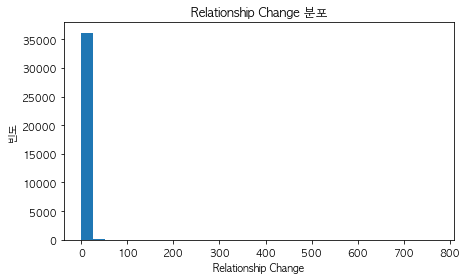

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(company_round['relationship_change'], bins=30)
plt.title('Relationship Change 분포')
plt.xlabel('Relationship Change')
plt.ylabel('빈도')
plt.show()


In [26]:
company_round['relationship_change'].describe()

count     36272.0
mean     1.938244
std      9.468066
min           0.0
25%           0.0
50%           0.0
75%           2.0
max         771.0
Name: relationship_change, dtype: Float64

### 투자 수 컬럼 생성

In [39]:
founder_master

,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,founder_round_relationship_change_median
0,p:10,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN,134
1,p:100017,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN,0
2,p:100025,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10
3,p:100026,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10
4,p:100048,c:79332,1,0,1,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
14742,p:9997,c:2726,1,0,1,NaN,NaN,NaN,NaN,NaN,2
14743,p:99977,c:81526,1,0,8,NaN,3.0,Computer Science / Software,massachusetts institute of technology (mit),NaN,2
14744,p:99979,c:81538,4,0,4,NaN,4.0,Arts / Humanities,NaN,NaN,1
14745,p:99980,c:81538,4,0,4,NaN,NaN,NaN,NaN,NaN,1


## 회사 기준 집계
- grain: 회사 (c:)
- 집계 해야하는 변수: 공동창업자 평균 학력, 창업자 중 최고 학위, 창업자 관계 변화량 중앙값

In [47]:
inv

,investments_id,funding_round_id,invested_c_id,investor_cfp_id
0,1,1,c:4,f:1
1,2,1,c:4,f:2
2,3,3,c:5,f:4
3,4,4,c:5,f:1
4,5,4,c:5,f:5
...,...,...,...,...
80897,80898,57882,c:285244,p:267312
80898,80899,57912,c:60389,p:268570
80899,80900,57929,c:286183,p:365
80900,80901,57929,c:286183,p:176466


In [48]:
# 회사별 투자 건수
company_invest_cnt = (
    inv
    .groupby('invested_c_id')
    .agg(vc_invest_cnt=('investments_id', 'nunique'))
    .reset_index()
)

# 창업자 기준으로 연결
founder_invest_cnt = (
    founder_master[['rel_p_id', 'rel_cf_id']]
    .merge(
        company_invest_cnt,
        left_on='rel_cf_id',
        right_on='invested_c_id',
        how='left'
    )
    .groupby('rel_p_id')
    .agg(
        founder_vc_invest_cnt=('vc_invest_cnt', 'sum')
    )
    .reset_index()
)

# founder_master 에 붙이기 (투자 건수)
founder_master = founder_master.merge(
    founder_invest_cnt,
    on='rel_p_id',
    how='left'
)

founder_master['founder_vc_invest_cnt'] = (
    founder_master['founder_vc_invest_cnt'].fillna(0)
)


In [49]:
founder_master

,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,founder_round_relationship_change_median,founder_vc_invest_cnt
0,p:10,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN,134,20
1,p:100017,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN,0,11
2,p:100025,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10,2
3,p:100026,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,10,2
4,p:100048,c:79332,1,0,1,NaN,NaN,NaN,NaN,NaN,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...
14742,p:9997,c:2726,1,0,1,NaN,NaN,NaN,NaN,NaN,2,18
14743,p:99977,c:81526,1,0,8,NaN,3.0,Computer Science / Software,massachusetts institute of technology (mit),NaN,2,2
14744,p:99979,c:81538,4,0,4,NaN,4.0,Arts / Humanities,NaN,NaN,1,2
14745,p:99980,c:81538,4,0,4,NaN,NaN,NaN,NaN,NaN,1,2


In [ ]:
# # csv 쓰기 (데이터 프레임 편집, 분석한 데이터 프레임 저장)
# founder_master.to_csv('cy_founder_master.csv', index=False)
# print("전처리된 데이터를 cy_founder_master.csv 파일로 저장했습니다.")

전처리된 데이터를 cy_founder_master.csv 파일로 저장했습니다.
